<a href="https://colab.research.google.com/github/glarmour/Congressional-Analytics/blob/main/GSB_521_Project_Build.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import json
from urllib.request import urlopen
import matplotlib.pyplot as plt

We will first collect data from the census on household incomes for every congressional dsitrict in each state. 

In [3]:
url="https://api.census.gov/data/2021/acs/acs1?get=NAME,B19001_001E,B19001_002E,B19001_017E&for=congressional%20district:*&in=state:*"
response = urlopen(url)
data_json = json.loads(response.read())
data_json.pop(0) 
cols = ['District Name','Total Households','Less than $10k', '$200k+', 'State code', 'district number']
acs_df = pd.DataFrame(data_json, columns = cols)
acs_df[['District', 'State']] = acs_df['District Name'].str.split(',', expand=True)
acs_df['district number'] = pd.to_numeric(acs_df['district number'])
acs_df['State'] = acs_df['State'].str.strip()
acs_df = acs_df[['Total Households', 'Less than $10k', "$200k+", 'district number', 'State']]
acs_df["Total Households"] = pd.to_numeric(acs_df["Total Households"])
acs_df["Less than $10k"] = pd.to_numeric(acs_df["Less than $10k"])
acs_df['$200k+'] = pd.to_numeric(acs_df['$200k+'])
acs_df['% of households over $200k'] = (100*acs_df['$200k+'])/acs_df['Total Households']
acs_df['% of households less than $10k'] = (100*acs_df['Less than $10k'])/acs_df['Total Households']

We will clean our congressional income data below.

In [4]:
party_df = pd.read_csv("http://goodcsv.com/wp-content/uploads/2020/08/us-house-of-representatives-2020.csv", encoding = "ISO-8859-1")
party_df['district number'] = party_df['District/Position'].str.extract('(\d+)')
party_df['district number'] = party_df['district number'].fillna(0)
party_df['district number'] = pd.to_numeric(party_df['district number'])
party_df['State'] = party_df['State/Territory']
party_df['State'] = party_df['State'].str.strip()
party_df['Party'] = party_df['Party'].str.strip() 
party_df = party_df[['State', 'Party', "district number"]]

In [5]:
merged_df = pd.merge(acs_df, party_df, on=["State", "district number"])

We will now import our data from the Social Security Department.

In [6]:
social_df = pd.read_csv("https://www.irs.gov/pub/irs-soi/20incd.csv")
social_df.head(5)

,STATEFIPS,STATE,CONG_DISTRICT,agi_stub,N1,MARS1,MARS2,MARS4,ELF,CPREP,...,N85300,A85300,N11901,A11901,N11900,A11900,N11902,A11902,N12000,A12000
0,0,US,0,0,161764910.0,82373910.0,54549620.0,20984710.0,149287910.0,4938790.0,...,5543730.0,33883499.0,32446310.0,213597271.0,123337290.0,458399327.0,120090880.0,367822468.0,4320870.0,88922085.0
1,1,AL,0,0,2216040.0,1029370.0,756390.0,378560.0,2049460.0,52470.0,...,44070.0,183122.0,406360.0,2190965.0,1735120.0,5926650.0,1701820.0,5305280.0,42980.0,600596.0
2,1,AL,0,1,82900.0,62170.0,14110.0,4550.0,68090.0,3570.0,...,0.0,0.0,2260.0,4247.0,60780.0,148578.0,60040.0,131494.0,870.0,12179.0
3,1,AL,0,2,288340.0,227550.0,25300.0,30890.0,260590.0,9690.0,...,0.0,0.0,19760.0,9358.0,230930.0,373937.0,230050.0,371051.0,1100.0,2120.0
4,1,AL,0,3,483010.0,282690.0,59640.0,131520.0,451300.0,11900.0,...,0.0,0.0,37700.0,36964.0,432240.0,1421325.0,430480.0,1415909.0,2390.0,5094.0


Our data needs to be cleaned so we can merge it with our political party data set and our congressional income data set. This is done below by converting each State abbreviation to the state's full name.

In [8]:

state_abbr_to_name = {'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 
                     'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 
                     'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho', 
                     'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas', 
                     'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland', 
                     'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 
                     'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 
                     'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York', 
                     'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma', 
                     'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina', 
                     'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 
                     'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 
                     'WI': 'Wisconsin', 'WY': 'Wyoming'}
social_df['State'] = social_df['STATE'].map(state_abbr_to_name)
social_df['district number'] = social_df['CONG_DISTRICT']
social_df.head(5)

,STATEFIPS,STATE,CONG_DISTRICT,agi_stub,N1,MARS1,MARS2,MARS4,ELF,CPREP,...,N11901,A11901,N11900,A11900,N11902,A11902,N12000,A12000,State,district number
0,0,US,0,0,161764910.0,82373910.0,54549620.0,20984710.0,149287910.0,4938790.0,...,32446310.0,213597271.0,123337290.0,458399327.0,120090880.0,367822468.0,4320870.0,88922085.0,NaN,0
1,1,AL,0,0,2216040.0,1029370.0,756390.0,378560.0,2049460.0,52470.0,...,406360.0,2190965.0,1735120.0,5926650.0,1701820.0,5305280.0,42980.0,600596.0,Alabama,0
2,1,AL,0,1,82900.0,62170.0,14110.0,4550.0,68090.0,3570.0,...,2260.0,4247.0,60780.0,148578.0,60040.0,131494.0,870.0,12179.0,Alabama,0
3,1,AL,0,2,288340.0,227550.0,25300.0,30890.0,260590.0,9690.0,...,19760.0,9358.0,230930.0,373937.0,230050.0,371051.0,1100.0,2120.0,Alabama,0
4,1,AL,0,3,483010.0,282690.0,59640.0,131520.0,451300.0,11900.0,...,37700.0,36964.0,432240.0,1421325.0,430480.0,1415909.0,2390.0,5094.0,Alabama,0


In [24]:
merged_df_final = pd.merge(merged_df, social_df, on=["State", "district number"])

merged_df_final.head(5)
                           
merged_df_final['Farm Returns']  = merged_df_final["SCHF"]





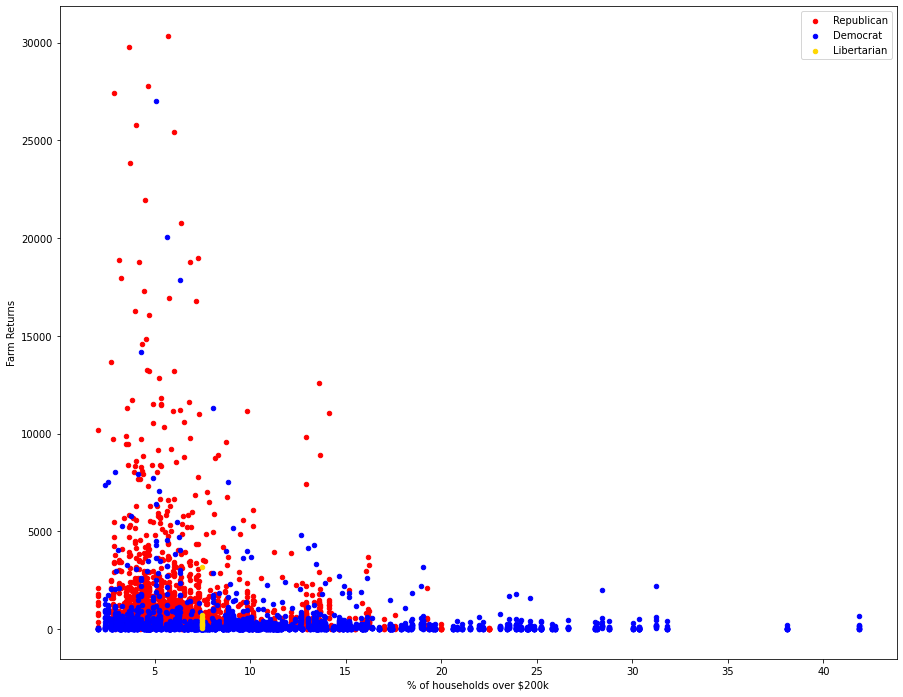

In [25]:
R = merged_df_final[merged_df_final['Party'].str.contains('R')]
D = merged_df_final[merged_df_final['Party'].str.contains('D')]
L = merged_df_final[merged_df_final['Party'].str.contains('L')]

fig, ax = plt.subplots(figsize=(15, 12))
R.plot.scatter(x='% of households over $200k', y='Farm Returns', c='red',label='Republican', ax=ax)
D.plot.scatter(x='% of households over $200k', y='Farm Returns',c='blue',label='Democrat', ax=ax)
L.plot.scatter(x='% of households over $200k', y='Farm Returns',c='gold',label='Libertarian', ax=ax)

#for i, txt in enumerate(df['State']):
#   ax.annotate(txt, (df['% of households over $200k'].iat[i], df['% of households less than $10k'].iat[i]))

plt.legend()
plt.show()

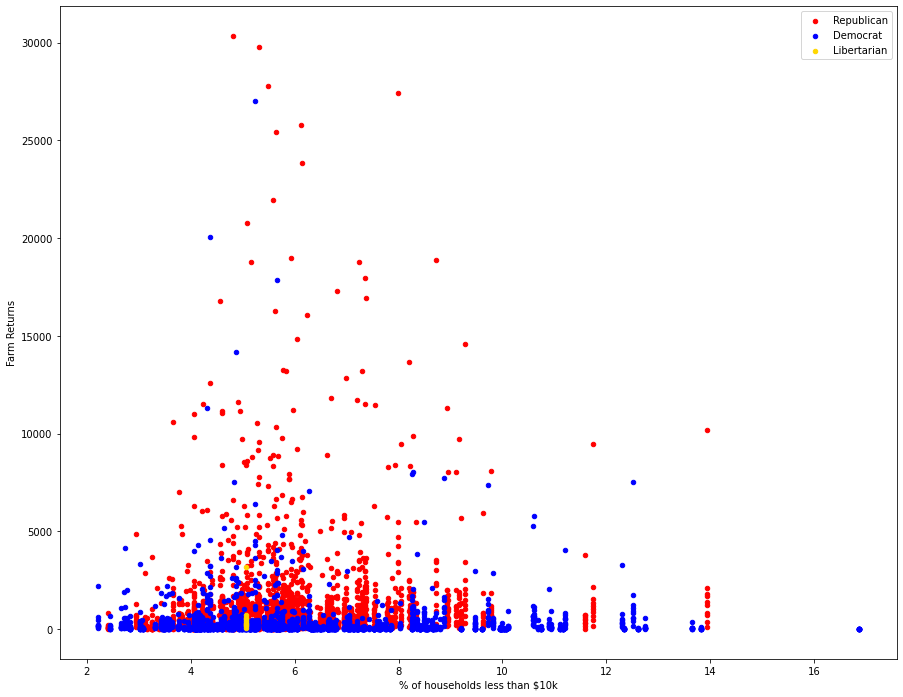

In [26]:
R = merged_df_final[merged_df_final['Party'].str.contains('R')]
D = merged_df_final[merged_df_final['Party'].str.contains('D')]
L = merged_df_final[merged_df_final['Party'].str.contains('L')]

fig, ax = plt.subplots(figsize=(15, 12))
R.plot.scatter(x='% of households less than $10k', y='Farm Returns', c='red',label='Republican', ax=ax)
D.plot.scatter(x='% of households less than $10k', y='Farm Returns',c='blue',label='Democrat', ax=ax)
L.plot.scatter(x='% of households less than $10k', y='Farm Returns',c='gold',label='Libertarian', ax=ax)

plt.legend()
plt.show()